In [1]:
%load_ext autoreload

In [5]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [6]:
project_dir = './../DATA/Miami_data'
out_dir = './out_figures'
#os.chdir(project_dir)

geom_dsm = project_dir + '/dsm_reprojected_wgs84.tif'

out_amplitude = project_dir + '/mean_amplitude'

plt.rcParams["font.size"] = "25"

In [13]:
def get_data(lats, lons, box_rdr, ps, out_amplitude, shift=0, corrected=False):
    demError_file = project_dir + '/demErr.h5'
    demError_std_file = project_dir + '/demErr_std.h5'

    vel_file = project_dir + '/velocity.h5'
    if corrected:
        geo_file = project_dir + '/corrected_geo/geometryRadar.h5'
        print('corrected')
    else:
        print('not corrected')
        geo_file = project_dir + '/org_geometry/geometryRadar.h5'

    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    
    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    DEM = readfile.read(geo_file, datasetName='height')[0]+26
    
    demError = readfile.read(demError_file, datasetName='dem')[0]
    demError_std = readfile.read(demError_std_file, datasetName='dem')[0]

    velocity, atr = readfile.read(vel_file, datasetName='velocity')
    velocity -= velocity[refy, refx]

    mask = np.ones(velocity.shape, dtype=np.int8)
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0
    
    
    xmin = box_rdr[0]
    xmax = box_rdr[1]
    ymin = box_rdr[2]
    ymax = box_rdr[3]
    
    am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))

    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask *= mask_p
    else:
        mask *= mask_t
    
    
    vel = np.array(velocity[mask==1]*1000)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    demerr = np.array(demError[mask==1])
    demerror_std = np.array(demError_std[mask==1])
    dem = np.array(DEM[mask==1])
    
    
    mask = np.zeros(velocity.shape)
    mask[ymin:ymax, xmin:xmax] = 1
    
    if ps:
        mask *= mask_p
    else:
        mask *= mask_t
    
    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)
    
    xv = np.array(x[mask==1])-xmin
    yv = ymax - np.array(y[mask==1])-1
    ddemerr = np.array(demError[mask==1])
    ddem = np.array(DEM[mask==1])
  
    return amplitude, xv, yv, lon, lat, vel, demerr, demerror_std, dem, ddemerr, ddem



def plot_subset(box,  box_rdr, ps, vel_range, amplitude_im, dem_offset, 
                dem_name, out_name, out_dir, f1, f2, corrected,ampmax=300, pdd=0.08):
    
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    padding=0.02
    scale=70
    
    amplitude,  xv, yv, lon, lat, vel, demerr, demerror_std, dem , ddemerr, ddem = get_data(lats, lons,box_rdr, ps, amplitude_im, dem_offset, corrected)
    amplitudep,  xvp, yvp, lonp, latp, velp, demerrp, demerror_stdp, demp , ddemerrp, ddemp = get_data(lats, lons,box_rdr, True, amplitude_im, dem_offset, corrected)
        
    
    opt = ' --notitle --fontsize 12 --nocbar --alpha 1 '
    opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray' # -u cm '
    opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
    opt += ' --noverbose --noreference --noscalebar' #.format(reflat, reflon)
    
    
    data_mud2 = project_dir + '/geo/geo_velocity.h5'
    mask_ps_file = project_dir + '/geo/geo_maskPS.h5'
    
    
    cmd = 'view.py {} '.format(geom_dsm) + opt 
    #cmd += ' --dem {} --dem-nocontour --contour-smooth 0.0 --shade-az 45 '.format(geom_dsm)
    #cmd += ' --shade-exag 0.01 --shade-min 0 --shade-max 30 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lats[0], lats[1], lons[0], lons[1])
    
    
    
    fig, _axs = plt.subplots(nrows=1, ncols=4, 
                        figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    axs = _axs.flatten()
    
    
    ax1 = axs[0]
    ax1.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax1, d_v, atr, inps)[2:4]
    
    
    ax2 = axs[1]

    
    ax3 = axs[2]
    ax3.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax3, d_v, atr, inps)[2:4]
    
    ax4 = axs[3]
    ax4.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax4, d_v, atr, inps)[2:4]
    
    
    #####  1
    im2 = ax1.scatter(lonp, latp, c=velp/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range);
    im = ax1.scatter(lon, lat, c=vel/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range); 
    im.set_zorder(20)
    im2.set_zorder(25)
    
    geo_box = (lons[0], lats[0], lons[1], lats[1])
    pp.draw_scalebar(ax1, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    cbar = plt.colorbar(im, ax=ax1, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('velocity [cm/yr]')
    #cbar.set_label('DEM Error [m]')
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    
    #####   2
    imm=ax2.imshow(amplitudep, cmap='gray', vmin=0, vmax=ampmax, origin='upper')
    
    im = ax2.scatter(xv, yv, c=-ddemerr+ddem, s=scale, cmap='jet'); 
    im.set_zorder(20)
    im1 = ax2.scatter(xvp, yvp, c=-ddemerrp+ddemp, s=scale, cmap='jet'); 
    im1.set_zorder(20)
    cbar = plt.colorbar(im1, ax=ax2, shrink=0.6, orientation='horizontal', pad=pdd)
    cbar.set_label('Estimated \nelevation [m]')
           
    cbar_ax = fig.add_axes([0.35, 0.8, 0.1, 0.018])
    fig.colorbar(imm, cax=cbar_ax, ticks=[0, ampmax], label='Amplitude', 
                 orientation='horizontal', pad=padding)
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_label_position('top')
 
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    
    #####   3
    im1 = ax3.scatter(lon, lat, c=-demerr+dem, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(20)
    im2 = ax3.scatter(lonp, latp, c=-demerrp+demp, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im2.set_zorder(25)
        
    cbar = plt.colorbar(im1, ax=ax3, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('Estimated \nelevation [m]')
    #cbar.set_label('Elevation [m]')
    #pp.draw_scalebar(ax3, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    
    #####   4
    #im = ax3.scatter(lon, lat, c=-demerr, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im = ax4.scatter(lon, lat, c=demerror_std, s=scale, cmap='jet', vmin=0, vmax=20); 
    im.set_zorder(20)
    im1 = ax4.scatter(lonp, latp, c=demerror_stdp, s=scale, cmap='jet', vmin=0, vmax=20); 
    #im1 = ax3.scatter(lonp, latp, c=-demerrp, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(25)
    cbar = plt.colorbar(im, ax=ax4, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('DEM error \nSTD [m]')
    ax4.axes.get_xaxis().set_visible(False)
    ax4.axes.get_yaxis().set_visible(False)
    
    

    
    if ps:
        psds = 'ps'
    else:
        psds = 'ds'
    #plt.savefig(out_dir + '/{}_{}_{}.png'.format(out_name, dem_name, psds),bbox_inches='tight', dpi=300)
    
    

corrected
corrected
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


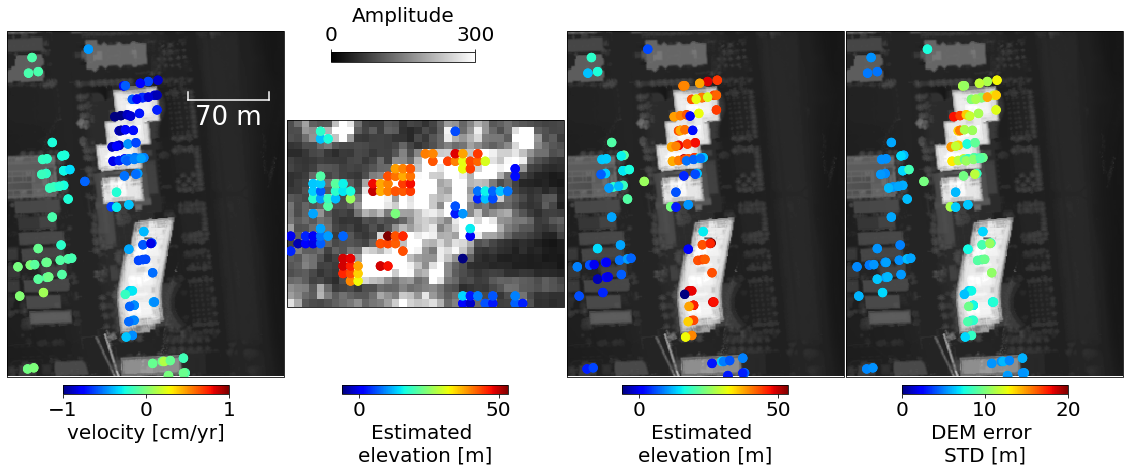

In [14]:
# PS velocity and DEM error after geolocation correction

refy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=1, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=50, corrected=True, pdd=0.18)


corrected
corrected
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


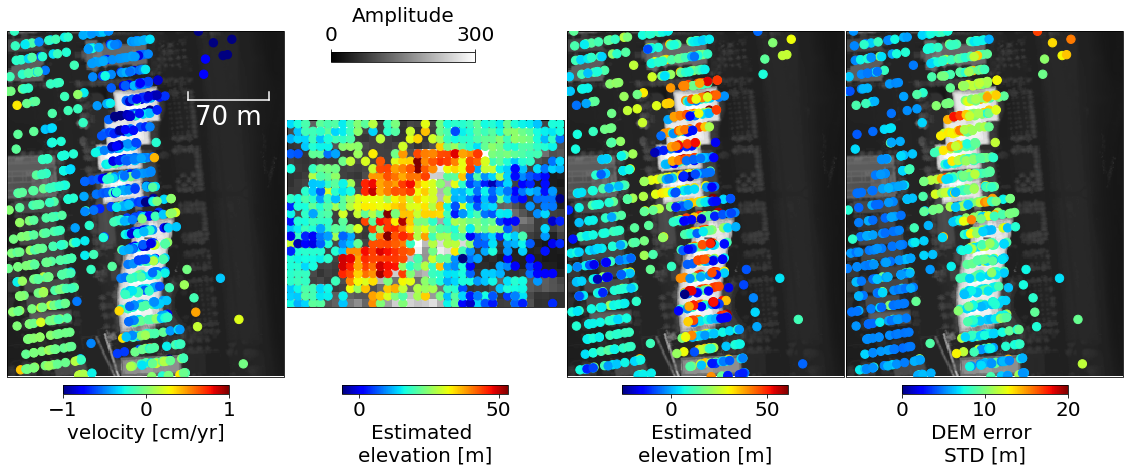

In [15]:
# DS velocity and DEM error after geolocation correction

refy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=1, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=50, corrected=True, pdd=0.18)

In [11]:
def get_data_ts(point, box, ps, yx=False):
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    ts_file = project_dir + '/timeseries_SET_ERA5_demErr.h5'
    geo_file = project_dir + '/corrected_geo/geometryRadar.h5'
    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    vel_file = project_dir + '/velocity.h5'
    
    velocity = readfile.read(vel_file, datasetName='velocity')[0]*1000
    
    stack_obj = timeseries(ts_file)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    mask_v = np.ones(velocity.shape)
    mask_v[np.abs(velocity) < 3] = 0
    


    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]*mask_v
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0

    
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    ts = np.zeros([len(lat), num_dates])
    
    ts_p = np.zeros([point.shape[0], num_dates])
    ts_std = np.zeros([point.shape[0], num_dates])
    
    for i in range(point.shape[0]):
        if yx:
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_yx(point[i, 0], point[i, 1], ts_file, 
                                                      ref_y=refy, ref_x=refx,
                                                      win_size=2, unit='cm', print_msg=True)
        else:
            
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_lalo(point[i, 0], point[i, 1], ts_file, 
                                                      lookup_file=geo_file, ref_lat=reflat, ref_lon=reflon,
                                                      win_size=2, unit='cm', print_msg=True)
            
    
    #for i in range(len(lat)):
    #    dates_ts, ts[i, :] = ut.read_timeseries_lalo(lat[i], lon[i], ts_file, 
    #                                              lookup_file=geo_file, ref_lat=reflat, ref_lon=reflon,
    #                                              win_size=2, unit='mm', print_msg=True)[0:2]
    
    
    return lon, lat, dates_ts, ts, ts_p, ts_std

input y / x: 337 / 1504
input y / x: 334 / 1519


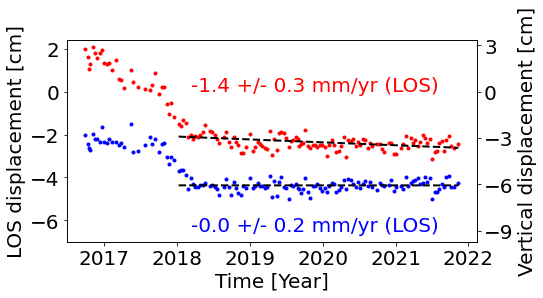

In [12]:
refy = 319
refx = 1489

box = ['25.876:25.879','-80.1224:-80.120'] 
point = np.array([[25.8782, -80.1218],
                  [25.8778, -80.1213]])

point = np.array([[337, 1504],
                  [334, 1519]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "20"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = ax1.twinx()
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] + 2, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] - 2, '.', color='blue', linewidth=2)


xx = [(x-dates_ts[35]).days for x in dates_ts[35::]]
res1 = stats.linregress(xx, ts_p[0, 35::]-ts_p[0, 4]+2)
ax1.plot(dates_ts[35::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[40], -0, '{:.1f} +/- {:.1f} mm/yr (LOS)'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, 35::]-ts_p[1, 4]-2)
ax1.plot(dates_ts[35::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[40], -6.5, '{:.1f} +/- {:.1f} mm/yr (LOS)'.format(res1.slope*3652.5, res1.stderr*3652.), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
y1lim = np.array([-7, 2.4])
y2lim = y1lim / np.cos(np.deg2rad(44))

ax1.set_ylim(y1lim)
ax2.set_ylim(y2lim)
ax2.set_yticks([-9, -6, -3, 0, 3])
ax2.set_ylabel('Vertical displacement [cm]')

#plt.savefig(out_dir + '/ref_miami_ts_hotel.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [20]:
def get_data(ymin, ymax, xmin, xmax, ps, out_amplitude, shift=0):
    demError_file = project_dir + '/demErr.h5'
    demError_std_file = project_dir + '/demErr_std.h5'

    vel_file = project_dir + '/velocity.h5'
    geo_file = project_dir + '/org_geometry/geometryRadar.h5'
    #dsm_file = project_dir + '/dsm.h5'

    phs_file = project_dir + '/phase_series.h5'
    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'

    
    mask_w = np.flipud(readfile.read(mask_file_w, datasetName='mask')[0][ymin:ymax, xmin:xmax])
    mask_t = np.flipud(readfile.read(mask_file_t, datasetName='mask')[0][ymin:ymax, xmin:xmax])*mask_w
    mask_p = np.flipud(readfile.read(mask_file_ps, datasetName='mask')[0][ymin:ymax, xmin:xmax])*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    DEM = np.flipud(readfile.read(geo_file, datasetName='height')[0][ymin:ymax, xmin:xmax]) + shift

    demError = np.flipud(readfile.read(demError_file, datasetName='dem')[0][ymin:ymax, xmin:xmax])
    demError_std = np.flipud(readfile.read(demError_std_file, datasetName='dem')[0][ymin:ymax, xmin:xmax]) 

    velocity, atr = readfile.read(vel_file, datasetName='velocity')
    velocity = np.flipud(velocity[ymin:ymax, xmin:xmax])
  
    am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))

    vel = velocity[mask==1]*1000
   
    demerr = demError[mask==1]
    dem = DEM[mask==1]
    demerror_std = demError_std[mask==1]

    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)

    xv = x[mask==1]
    yv = y[mask==1]
    
    return amplitude, xv, yv, vel, demerr, dem, demerror_std, DEM, atr


def plot_subset(ymin, ymax, xmin, xmax, ps, vel_range, amplitude_im, dem_offset, dem_name, out_name, out_dir, size=100):
    
    amplitude, xv, yv, vel, demerr, dem, demerror_std, DEM, atr = get_data(ymin, ymax, xmin, xmax, ps, amplitude_im, dem_offset)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    #amplitude = (amplitude - np.min(amplitude))/(np.max(amplitude) - np.min(amplitude))
    
    ax = axs[0,0]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=vel/10, s=size, cmap='jet', vmin=-vel_range, vmax=vel_range); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('velocity [cm/yr]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[0,1]
    im=ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('Amplitude')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[1,0]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=dem, s=size, cmap='jet'); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('SRTM DEM [m]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[1,1]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=-demerr, s=size, cmap='jet'); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('DEM Error [m]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
    ax.axes.get_yaxis().set_visible(False)
    
    if ps:
        psds = 'ps'
    else:
        psds = 'ds'
    plt.savefig(out_dir + '/{}_{}_{}.png'.format(out_name, dem_name, psds), dpi=300)


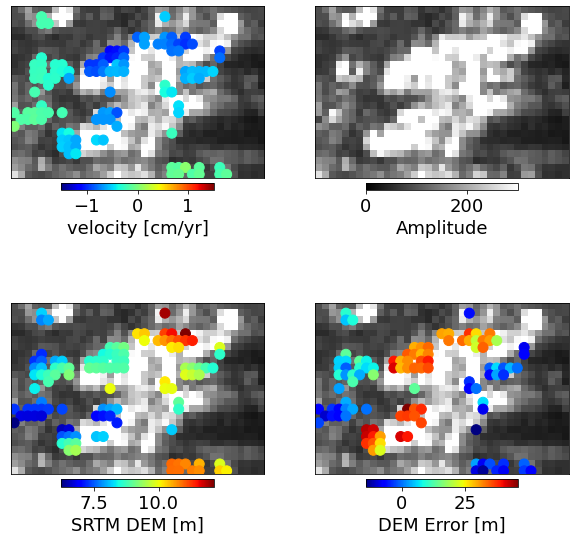

In [21]:
plt.rcParams["font.size"] = "18"

plot_subset(ymin=319, ymax=344, xmin=1490, xmax=1527, ps=True, vel_range=1.5,
            amplitude_im=out_amplitude, dem_offset=26, dem_name='Sdem', 
            out_name='hotel_radar_coord', out_dir=out_dir, size=100)